### Step 1. 스티커 구하기 or 만들기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


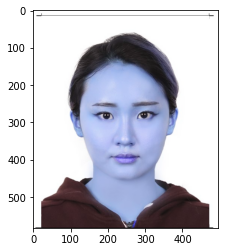

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path,-1)
img_show = img_bgr.copy() #이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용합니다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 그래서 여러분의 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것입니다. 
plt.imshow(img_bgr)
plt.show()


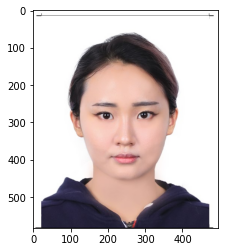

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

그럼 dlib을 활용해 hog detector를 선언해 보겠습니다.

In [4]:
# detector를 선언합니다.

detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


detector_hog를 이용해서 얼굴의 bounding box를 추출합니다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


찾은 얼굴을 화면에 출력해보겠습니다.

rectangles[[(111, 201) (379, 468)]]


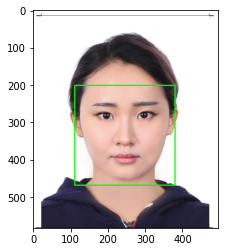

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

#dlib detector 는 dlib.rectangles 타입의 객체를 반환합니다. 
#dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.
#dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있습니다
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3-4. 얼굴 랜드마크 face landmark

### 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. 
### face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

저장한 landmark 모델을 불러옵니다.

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

#landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.
landmark_predictor = dlib.shape_predictor(model_path) 
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    # points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))   # 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다.

68


랜드마크를 영상에 출력해 보겠습니다.

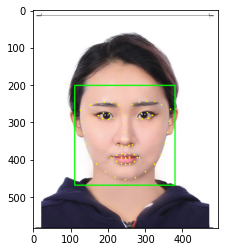

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3-5. 스티커 적용하기

이제 왕관 스티커를 머리에 씌울 준비가 되었습니다.

랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.

중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.

##### 1. 스티커 위치
##### x = x[nose]
##### y = y[nose]-(height/2)
##### 2. 스티커 크기
##### width=height=width bbox

좌표를 먼저 확인해 보겠습니다.

In [10]:
for dlib_rect, landark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index : 30
    x = landmark[30][0]  # 수염의 중앙 x좌표값
    y = landmark[30][1]  # 수염의 중앙 y좌표값
    w = h = dlib_rect.width() # 수염 스티커 resize를 위한 경계박스 너비, 높이
    print('(x,y) : (%d,%d)'%(x,t))
    print('(w,h) : (%d,%d)'%(w,h))

(246, 346)
(x,y) : (246,201)
(w,h) : (269,269)


제 얼굴 이미지에서는 코의 중심점이 (246, 346) 로 나오네요.

준비해 둔 스티커 이미지를 읽어서 적용해 보겠습니다.



(269, 269, 3)


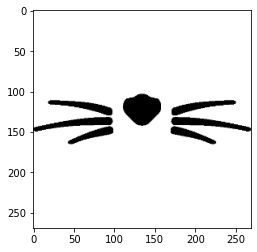

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)  # 스티커 이미지를 불러옵니다.
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)

In [12]:

# 스티커 이미지 좌표
refined_x = x - w // 2   # left
refined_y = y - h // 2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (112,212)


원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.



In [13]:

# y좌표가 음수일 때, -y만큼 이미지를 잘라준 후 y 경계값은 0으로 설정
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
print (img_sticker.shape)
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(269, 269, 3)
(x,y) : (112,212)


이제 원본 이미지에 스티커를 적용합니다.

In [14]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다
print("슝~")

슝~


img_show 에 다시 적용하겠습니다.

결과 이미지를 출력하면,

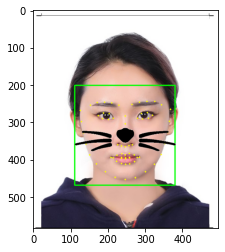

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 최종 결과만 출력해 봅시다. img_show 대신, 지금까지 아껴 두었던 img_bgr을 활용할 것입니다.

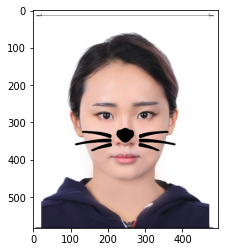

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

여러분이 사용하고 있는 어플의 초기 버전을 완성했습니다.

# 회고

**얼굴 각도에 따라 스티커가 어떻게 변해야할까요?**

우리가 스노우 캠으로 촬영을 할때처럼, 얼굴 각도에 맞추어서 스티커도 변경이 되어야 한다고 생각한다.
그러나, 평면적인 사진에서 단순히 회전만 적용한 사진에서는 스티커도 그에 맞춰 회전도 단순히 적용하기만 하면 되지만,
예를들어 얼굴을 45도 각도로 옆으로 튼다던지, 아예 정면이 아닌 옆모습을 보인 모습에서는 단순히 스티커를 회전하는 것으로는 약간 부족한 점이 있지 않나 싶다.
따라서, 단순한 평면을 넘어서 입체적으로 각도가 틀어진 모습에서도 적용이 될 수 있도록 스티커도 입체적으로 변화를 주어야 겠다고 생각했다.





**멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?**

만약 멀리서 촬영하거나 눕게 되면, 설사 얼굴의 위치는 인식이 되었을지라도 랜드마크의 좌표점과 일치되는 것에 어려움이 생겨서 그런것이라고 추측한다.





**실행 속도가 중요할까요?**

정지된 사진에서 스티커를 적용하는 등, 지금과 같이 변수가 통제된 제한적인 상황에서는 실행속도의 영향이 크게 와닿지 않을수 있으나,

스노우 카메라와 같은 경우 렌즈 속 인물은 정지된 사진처럼 가만히 있는 경우가 드물다.
따라서, 시시때때로 움직이는 인물에 바로 특수 효과(스티커, 배경 등)가 실시간으로 적용될 수록 있도록 하는 실행 속도의 영향은 매우 중요해진다.




**스티커앱을 만들 때 정확도가 얼마나 중요할까요?**

중요하다.
예를들어, 얼굴의 잡티를 제거해주는 특수 효과를 사진에 적용했을때, 눈이 작은 사람같은 경우 자신의 눈이 사라져 버린다면 매우 당황할 것이다.
또한 배경 특수 효과 같은 경우, 사람 뒤에 걸려 있는 옷을 사람으로 잘못 인식하고 인물 취급을 해서 배경 속에 묻히지 않는 경우도 종종 있다.

애초에 특수 효과를 적용하는 것 자체가, 목적성을 띄는 것이므로, 어느 부위에 어떤 효과를 적용할지에 대한 정확도는 매우 중요하다.





**내가 겪은 문제점**

내가 이번 노드를 하면서 겪은 문제점은 대표적으로 두가지가 존재했다.
첫번째는, 스티커의 위치를 지정하는데에 대한 어려움과
두번째는, 스티커의 구현이 잘못되는 것이다.

첫번째로, 스티커의 위치를 지정할때 얼굴이 아닌 계속해서 미간에 지정이 되기도 하고,
스티커의 크기가 얼굴에 비해 너무 큰것같아 좀 줄여보려고 하면 자꾸 초록 박스를 모서리 부분에 위치하거나 아님 아예 벗어나거나 하는 것이었다.
여러번의 시행 착오 끝에 정상적으로 위치할 수 있었다.

두번째로, 수염 스티커를 적용할때, 투명한 배경 부분은 하얗게, 까만 수염 부분은 투명하게 나와서 애를 먹었다.
끝부분에 있는 코드인 (np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8))중 img_sticker부분을 0이 아닌 255로 바꿔주니 정상적으로 색상이 구현이 되었다.




**심화**

***얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도***


스티커 이미지에 회전을 적용하기 위해  getRotationMatrix2D 라는 메서드를 찾게 되었다.
또한 이미지의 밝기는 얼굴을 인식하는데 영향을 주는 것으로 예측된다. 주어진 이미지가 어두울 수록, 이목구비를 잡아내는 것이 어려워질 것이다.
주어진 이미지가 어두워도 이목구비자체는 구분이 가능할 것이라고 생각했었는데,
좀 더 정교한 알고리즘이 필요한 것이 아닌가 싶다.
이렇게 생각하면 어두운 곳에서도 인간의 얼굴을 순식간의 알아채는 인간의 뇌가 얼마나 진화 되어있는지 또한번 생각해볼수 있는 좋은 기회였다.
또한 앞서 밝혔던 것처럼 촬영거리 또한 얼굴 인식에 영향을 줄 것이라고 예측한다.
우리가 사용하는 스냅카메라 같은 경우, 촬영 거리 가까이 있는 사람은 순식간에 예측을 하나, 잠깐 자세가 틀어져 렌즈에서 얼굴의 일부가 벗어나거나, 뒤에서 다른 사람이 등장하는 경우, 인물 인식을 하기는 하나, 깜빡깜빡 거리면서 인식이 불안정한 경우가 많으므로 영향이 클 것이라고 생각한다.
